In [44]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy.stats as stat
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
import warnings

We start from loading the dataset after data imputation:

In [2]:
#load data
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/house_model_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())
display(house_df.describe())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,1,1824,1824.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,1,1826,1824.0,1,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,1,1828,1824.0,2,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,1,1830,1824.0,3,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375


,is_incumbent,percent,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,fundraising
count,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9.974000e+03
mean,0.444456,50.968786,101123.196765,0.528474,1991.993884,1102.728093,0.963305,6.176784,0.481251,0.604071,0.493377,219.603971,210.664830,1.014975e+06
std,0.496930,19.917918,55100.387633,0.499214,31.278231,987.884433,1.826929,2.060743,0.499673,0.489074,0.062378,36.152015,34.645436,9.782140e+05
min,0.000000,0.000000,0.000000,0.000000,1824.000000,0.000000,0.000000,2.700000,0.000000,0.000000,0.395000,38.000000,86.000000,-3.469651e+04
25%,0.000000,36.160000,59347.250000,0.000000,1982.000000,0.000000,0.000000,4.600000,0.000000,0.000000,0.480000,194.000000,180.000000,5.015548e+05
50%,0.000000,50.235000,94682.000000,1.000000,2004.000000,1938.000000,0.000000,5.790931,0.000000,1.000000,0.490000,205.000000,225.000000,8.306668e+05
75%,1.000000,64.300000,136625.250000,1.000000,2012.000000,2002.000000,1.000000,7.000000,1.000000,1.000000,0.528000,248.000000,241.000000,1.329461e+06
max,1.000000,100.000000,322514.000000,1.000000,2018.000000,2018.000000,17.000000,19.000000,1.000000,1.000000,0.701000,334.000000,303.000000,3.410465e+07


We have some data where the president party is not defined: typically they're data from non-election years. Let's drop them.

In [3]:
#drop observations where president party is not defined
house_df=house_df.drop(house_df.loc[house_df['president_party']=="0"].index)

We define our baseline model simply taking the party, per each district, with the highest winning rate.

We prepare a dictionary `results` containing the winner parties of each year, grouped by state and district 

Also, we define `districtPredictions` and `districtAccuracy` that merge predictions with actual districts, so that accuracy is calculated on all existing districts, rather than only on the ones for which we have a predicted winner. In fact:
- based on the training set we might not have a prediction for all districts. As districts are redistributed through the years, one that is in the test set might not exist in the training set, so we have no prediction for it.
- we might have ex aequo winning predictions among candidates of opponent party, which do not lead to a winner prediction

In [4]:
#baseline model
def winnerFilter(df):
    return df[df['won']==1][['state','district','party']].replace(['D', 'R'], [0, 1])

def baselineTrain(df):
    df_grouped=df[(df['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    df_grouped['R_occurence']=df_grouped['party'].str.count('R')/df_grouped['party'].str.len()
    df_grouped['party']=(df_grouped['R_occurence']>0.5).astype(int)
    df_grouped['proba']=(1-df_grouped['party']-df_grouped['R_occurence']).abs()
    return df_grouped[['state', 'district','party', 'proba']]

#prepare dataset indexed by state and district, with all results 
results=dict()
for year in house_df['year'].unique():
    results[year]=house_df[house_df['year']==year].groupby(['state', 'district']).count()
    results[year]=results[year].drop(columns = list(results[year]))    
    results[year]['partyWon']=winnerFilter(house_df[house_df['year']==year]).set_index(['state','district']).sort_index()
def districtPredictions(y_pred, year, partyWonCol='party', set_index=1):
    if set_index:
        df=results[year].join(y_pred.set_index(['state', 'district'])).sort_index().fillna(-1)
    else:
        df=results[year].join(y_pred).fillna(-1)
    return df
def districtAccuracy(y_pred, year, partyWonCol='party', set_index=1):
    df=districtPredictions(y_pred, year, partyWonCol, set_index)
    return sum(df['partyWon']==df[partyWonCol])/len(df)

Using the above functions, we calculate the accuracy of the baseline model over the 2018 test set:

In [5]:
y_pred=baselineTrain(house_df[house_df['year']!=2018]) #train simple average model, remove 2018 results
baseline_accuracy=districtAccuracy(y_pred, 2018)
print('Baseline 2018 test accuracy: \t{:.2%}'.format(baseline_accuracy))

Baseline 2018 test accuracy: 	76.78%


We define a function for splitting the dataset:
- test set on data belonging to a specified input `year`
- trainng set on data from remaining years
- store `state`, `district` and `party` information using the same original index as the main data
- drop response features like `percent` and `votes`, plus `state`, `district` and `name`
- split into `x_train` and `y_train`, `x_test` and `y_test`, using `won` as response feature
- return

In [6]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    indexed_party=dfcopy[['party']].replace(['D', 'R'], [0, 1])
    dfcopy=dfcopy.drop(columns=['state', 'district', 'name', 'percent', 'votes'])
    #dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]
    #data_train, data_test=dfcopy[dfcopy['year']<year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts, indexed_party

In [7]:
#plot cross validation scores of decision trees
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.axhline(y=1, c='g', label='100% accuracy')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
#plot scores of a model through years
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, Accu_val_2_byDistrict, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'Full training set')
    ax.plot(years, scores_train_CV, label = 'CV mean score')
    ax.plot(years, scores_CV_mutExcl, label = 'CV mean mutually exclusive score')
    ax.plot(years, Accu_val_2_byDistrict, label = 'CV mean mutually exclusive score by district')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
#bar plot with model scores
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy):
    #plot
    current_palette = sns.color_palette()
    fig, ax = plt.subplots(1, 1, figsize=(10, 1.5*len(models_names)))
    fig.suptitle('Scores of all fitted models on training vs cross-validation means', fontsize=24, y=1) 
    w=0.2
    a=np.arange(len(models_names))
    ax.barh(a+1.5*w, scores_train, height=w,align='center', color=current_palette[0], alpha=0.5, label='train set') 
    ax.barh(a+0.5*w, scores_val, height=w,align='center', color=current_palette[1], alpha=0.5, label='CV set')   
    ax.barh(a-0.5*w, scores_val_mut_escl, height=w,align='center', color=current_palette[2], alpha=0.5, label='CV set mut. excl.')  
    ax.barh(a-1.5*w, scores_val_mut_escl_byDistrict, height=w,align='center', color=current_palette[3], alpha=0.5, label='CV set mut. excl. by district')  
    
    for i, v in enumerate(scores_train):
        ax.text(v-0.025, i+1.5*w, '{:>.2%}'.format(v), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val[i]-0.025, i+0.5*w, '{:>.2%}'.format(scores_val[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl[i]-0.025, i-0.5*w, '{:>.2%}'.format(scores_val_mut_escl[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl_byDistrict[i]-0.025, i-1.5*w, '{:>.2%}'.format(scores_val_mut_escl_byDistrict[i]), color='white', fontsize=12, verticalalignment='center')
  
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    ax.text(baseline_accuracy, -1, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    ax.set_yticklabels(models_names, fontdict=None, minor=False) 
    ax.set_yticks(a, minor=False)
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.35, 0.84));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    scores_stacking=[]
    scores_val_mut_escl_byDistrict=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
        scores_val_mut_escl_byDistrict.append(model['score val mut exclusive by district']) 
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy)

In [8]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democrat district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    house_df_all_districts['partisanship']=house_df_all_districts['partisanship'].astype(int)
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1).fillna(0)
    out_df['partisanship']=out_df['partisanship'].astype(int)
    return out_df

In the `designFeatures` function we applied mathematical transformations, convert strings to numbers, produced an amount of interaction terms, fixed a bug in the `first_time_elected` feature. 

The partisanship function gives an indication in case a district is traditionally tied to a party rather than the other. 

All features referring to an absolute party (R or D) have been changed so that they relate to the candidate's party, instead. For example, the district partisanship (democrat or republican or none) is changed to district partisanship for candidate's party.

To decide which columns to drop, we looked at the feature importance of the logistic regression model.

In [49]:
def designFeatures(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    #df_out=df_out.drop('first_time_elected', axis=1)
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #president party is same party as candidate
    df_out['own_president_party']=(df_out['president_party']==df_out['party']).astype(int)
    df_out['own_last_house_majority']=(df_out['last_house_majority']==df_out['party']).astype(int)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Is district partisan of the candidate's party?
    df_out['ownPartisan']=((df_out['partisanship'].astype(int))-df_out['party'].astype(int)==2).astype(int)
    df_out['swingDistrict']=(df_out['partisanship'].astype(int)==1).astype(int)
    df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True) #
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #President job approval or opposition
    df_out['own_president_job_approval']=((df_out['own_president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    df_out['president_opposition_job_approval']=((df_out['party']-df_out['president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    
    #Own president unemployment rate or opposition
    df_out['unemployement_rate_own_president']=df_out['own_president_party']*df_out['unemployement_rate']
    df_out['unemployement_rate_president_opposition']=(df_out['party']-df_out['president_party']).abs()*df_out['unemployement_rate']
    
    #drop party-related features
    #df_out=df_out.drop('last_R_vs_D_Seats', axis=1) #
    #df_out=df_out.drop('president_party', axis=1) #
    #df_out=df_out.drop('party', axis=1)
    #df_out=df_out.drop('last_house_majority', axis=1) #
    
    #drop multifactors features
    #df_out=df_out.drop('partisanship', axis=1)
    
    #drop president-related features, without specification for candidates party
    #df_out=df_out.drop('president_can_be_re_elected', axis=1) #
    #df_out=df_out.drop('president_overall_avg_job_approval', axis=1) #
    
    #drop unnecessary features
    #df_out=df_out.drop('is_presidential_year', axis=1) #
    #df_out=df_out.drop('year', axis=1)
    
    #drop collinear features
    #df_out=df_out.drop('unemployement_rate', axis=1)
    #df_out=df_out.drop('first_time_elected', axis=1)
    #df_out=df_out.drop('count_victories', axis=1)
    #df_out=df_out.drop('is_incumbent', axis=1)
    
    return df_out

The `MutuallyExclusivePredictions` function is used to tangibly increase the prediction accuracy, leveraging the fact that we need one winner per district:
- calculates score of the fitted input `model` on training and test set 
- perform a mutual exclusive win assignment
- return predictions and all three accuracy scores (train, test, test mutual exclusive)

About the mutual exclusive assignment, at that point we have a prediction per each candidate, but we don't check to have only one predicted winner per district, so we need to take only one winner per district:
- Group by district and assign win only to the candidate with highest win probability
- In case of more than one candidate with exact the same winning probability in the same district:
    - If those candidates belong to the same party, assign win only to the first one (in our scope we care about the winning party, not the candidate)
    - If those candidates belong to different parties, we can say nothing therefore we don't have a winner prediction for that district
- Calculate the accuracy score of the resulting predictions 

In [10]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts, indexed_party):
    #y_test is used only for accuracy score
    
    x_traincopy=x_train.copy()
    x_testcopy=x_test.copy()
    
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_traincopy)
    y_pred_test=model.predict(x_testcopy)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    #y_pred_train=model.predict_proba(x_traincopy)[:,1]
    y_pred_test=model.predict_proba(x_testcopy)[:,1]

    #Add index to predictions from X set
    #y_pred_train_df=pd.DataFrame(y_pred_train, index=x_traincopy.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_testcopy.index, columns=['abs_won_proba'])

    #Join party data to train and test datasets by index
    if 'party' not in list(x_traincopy):
        #x_traincopy=indexed_party.join(x_traincopy).dropna()
        x_testcopy=indexed_party.join(x_testcopy).dropna()
   
    #Join district data, party and predictions by index
    #districts_pred_train=indexed_districts.join(x_traincopy[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_testcopy[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        #display warning
        warnings.warn("\n{} districts have no winner or more than one winner.\nFollowing the list of affected districts:".format(len(NotJustOneWinner), DeprecationWarning))
        #print('List of affected districts:')
        display(districtWinners[districtWinners['won_pred']!=1])
        print('First occurrence from list:')
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_testcopy).join(y_pred_test_df).dropna()
        print('Data of the occurrence from list:')
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #manage conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state'].unique():
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district'].unique():
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict in {}, {} is between candidates from the same party, so we predict as winner in the district the first candidate of this party'.format(state, district))
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [11]:
#pre-process of the data: split, design features, standardization
def pre_process(df, year):
    #split dataset
    x_train, y_train, x_test, y_test, df_districts, df_party = splitDf(df, year)

    #designFeatures
    x_train_designFeatures=designFeatures(x_train, y_train, df_districts, x_train)
    x_test_designFeatures=designFeatures(x_train, y_train, df_districts, x_test)

    #Standardize
    columns=list(x_train_designFeatures.select_dtypes(include='float'))
    scaler = StandardScaler().fit(x_train_designFeatures[columns])
    x_train_designFeatures.loc[:, columns]=scaler.transform(x_train_designFeatures[columns])
    x_test_designFeatures.loc[:, columns]=scaler.transform(x_test_designFeatures[columns])
            
    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_designFeatures=x_train_designFeatures[list(x_test_designFeatures)]
    
    return x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party 

In [12]:
#train all models doing cross-validation through the years and store accuracy
def modelListTrain(modelList, train_df, years):
    train_data=train_df.copy()
    for i in range(len(modelList)):
        model=modelList[i]
        #intialize lists
        train_acc=[] #list with training accuracy
        val_acc=[] #list with validation accuracy
        val_acc_2=[] #list with mutually exclusive validation accuracy
        Accu_val_2_byDistrict=[] #list with mutually exclusive validation accuracy by district
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))

            #pre_process
            x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)
            
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)
            Accu_val_2_byDistrict.append(districtAccuracy(pred_df[pred_df['won_pred']==1], year))
            
            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\nMutually exclusive validation accuracy by district: {:.2%}\n'.format(train_acc[-1], val_acc[-1], val_acc_2[-1], Accu_val_2_byDistrict[-1]))
        #plot this model scores through years
        title='Scores of model {} cross-validated through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, Accu_val_2_byDistrict, title, xlabel='Year')
        #store model scores into model list (mean of all years folds)
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['score val mut exclusive by district']=np.mean(Accu_val_2_byDistrict)
           
    display(modelList)

In [13]:
#training set on data starting from yearStart until before 2018, test set on 2018 data
yearStart=1948
train_data, test_data = house_df[(house_df['year']>=yearStart)&(house_df['year']!=2018)], house_df[house_df['year']==2018]

In [14]:
#Years lists for cross-validation folds
Midterm_recent_years=2014-4*np.arange(10)
display(Midterm_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

In [15]:
#define models to be trained
modelList=[]
#Logistic regression
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#Logistic regression
#model=dict()
#model['name']='Logistic Regression CV=5, penalty=l1'
#model['model']=LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=2500)
#modelList.append(model)
#LDA
model=dict()
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
#Simple decision tree 
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Simple decision tree 
#max_depth=11
#model=dict()
#model['name']='Decision Tree, depth={}'.format(max_depth)
#model['model']=DecisionTreeClassifier(max_depth = max_depth)
#modelList.append(model)
#Random forest
max_depth=17
n_trees=100
model=dict()
model['name']='Random Forest of {} depth-{} trees'.format(n_trees, max_depth)
model['model']=RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth )
modelList.append(model)
#Boosting 
max_depth=1
n_trees=400
lrate=0.01
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_trees, learning_rate=lrate)
model=dict()
model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, max_depth)
model['model']=abc
modelList.append(model)  

#years=Midterm_recent_years

model: Logistic Regression CV=5
year: 2014
Training accuracy: 89.17%
Validation accuracy: 89.25%
Mutually exclusive validation accuracy: 92.00%
Mutually exclusive validation accuracy by district: 92.79%

model: Logistic Regression CV=5
year: 2010
Training accuracy: 89.76%
Validation accuracy: 84.28%
Mutually exclusive validation accuracy: 84.85%
Mutually exclusive validation accuracy by district: 85.45%

model: Logistic Regression CV=5
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.079562,0.0,0.288663,0.275621
5538,Texas,District 22,1.0,0.104551,1.0,0.288663,0.362189
5539,Texas,District 22,1.0,0.104551,1.0,0.288663,0.362189


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.079562
5538,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.104551
5539,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.104551


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.46%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: Logistic Regression CV=5
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.39901,1.0,1.197031,0.333333
4460,Louisiana,District 1,1.0,0.39901,1.0,1.197031,0.333333
4461,Louisiana,District 1,1.0,0.39901,1.0,1.197031,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.39901
4460,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.39901
4461,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.39901


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.53%
Validation accuracy: 84.69%
Mutually exclusive validation accuracy: 87.94%
Mutually exclusive validation accuracy by district: 89.70%

model: Logistic Regression CV=5
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.172418,0.0,0.563081,0.306206
3719,California,District 1,1.0,0.195331,1.0,0.563081,0.346897
3720,California,District 1,1.0,0.195331,1.0,0.563081,0.346897


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.172418
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.195331
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.195331


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.26%
Validation accuracy: 94.37%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 97.54%

model: Logistic Regression CV=5
year: 1994
Training accuracy: 89.41%
Validation accuracy: 88.62%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: Logistic Regression CV=5
year: 1990
Training accuracy: 89.55%
Validation accuracy: 87.23%
Mutually exclusive validation accuracy: 91.49%
Mutually exclusive validation accuracy by district: 91.89%

model: Logistic Regression CV=5
year: 1986
Training accuracy: 89.49%
Validation accuracy: 89.39%
Mutually exclusive validation accuracy: 95.45%
Mutually exclusive validation accuracy by district: 95.52%

model: Logistic Regression CV=5
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.180060,1.0,0.522512,0.344605
2528,California,District 43,0.0,0.162392,0.0,0.522512,0.310791
2569,California,District 43,1.0,0.180060,1.0,0.522512,0.344605


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.180060
2528,California,District 43,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.162392
2569,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.180060


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.45%
Validation accuracy: 88.28%
Mutually exclusive validation accuracy: 89.06%
Mutually exclusive validation accuracy by district: 91.04%

model: Logistic Regression CV=5
year: 1978
Training accuracy: 89.55%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 82.46%
Mutually exclusive validation accuracy by district: 83.05%

model: LDA
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.84%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 91.75%
Mutually exclusive validation accuracy by district: 92.56%

model: LDA
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 87.64%
Validation accuracy: 81.44%
Mutually exclusive validation accuracy: 83.71%
Mutually exclusive validation accuracy by district: 84.36%

model: LDA
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.012519,0.0,0.053948,0.232053
5538,Texas,District 22,1.0,0.020714,1.0,0.053948,0.383974
5539,Texas,District 22,1.0,0.020714,1.0,0.053948,0.383974


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.012519
5538,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.020714
5539,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.020714


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.17%
Validation accuracy: 87.96%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: LDA
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.144755,1.0,0.434265,0.333333
4460,Louisiana,District 1,1.0,0.144755,1.0,0.434265,0.333333
4461,Louisiana,District 1,1.0,0.144755,1.0,0.434265,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.144755
4460,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.144755
4461,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.144755


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.03%
Validation accuracy: 72.85%
Mutually exclusive validation accuracy: 87.94%
Mutually exclusive validation accuracy by district: 89.70%

model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.047558,0.0,0.178636,0.266230
3719,California,District 1,1.0,0.065539,1.0,0.178636,0.366885
3720,California,District 1,1.0,0.065539,1.0,0.178636,0.366885


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.047558
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.065539
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.065539


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.08%
Validation accuracy: 91.77%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 97.54%

model: LDA
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 87.21%
Validation accuracy: 87.43%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: LDA
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 87.22%
Validation accuracy: 87.23%
Mutually exclusive validation accuracy: 91.49%
Mutually exclusive validation accuracy by district: 91.89%

model: LDA
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 87.17%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 93.94%
Mutually exclusive validation accuracy by district: 94.03%

model: LDA
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.060349,1.0,0.171622,0.351639
2528,California,District 43,0.0,0.050924,0.0,0.171622,0.296722
2569,California,District 43,1.0,0.060349,1.0,0.171622,0.351639


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.060349
2528,California,District 43,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.050924
2569,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.060349


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.25%
Validation accuracy: 85.16%
Mutually exclusive validation accuracy: 89.06%
Mutually exclusive validation accuracy by district: 91.04%

model: LDA
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 87.24%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 87.72%
Mutually exclusive validation accuracy by district: 88.14%

model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
25 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
199,Michigan,District 11,2.0
200,Michigan,District 12,2.0
201,Michigan,District 14,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.18673,1.0,0.37346,0.5
8120,Arkansas,District 2,1.0,0.18673,1.0,0.37346,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.894206,0.0,0.976625,-0.526534,-0.527394,-0.028693,0.434383,1.0,0.0,0.0,1.0,-0.510698,0.906543,-0.992113,0.894873,-0.914246,0.18673
8120,Arkansas,District 2,-0.894206,1.0,0.976625,-0.526534,-0.527394,-0.028693,0.222474,0.0,1.0,0.0,1.0,0.510036,-0.977267,0.891796,-0.900036,0.885220,0.18673


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.81%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 92.50%
Mutually exclusive validation accuracy by district: 90.70%

model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
15 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
176,Mississippi,District 4,2.0
198,New York,District 20,2.0
221,Ohio,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.204904,1.0,0.409807,0.5
6570,Alabama,District 5,0.0,0.204904,1.0,0.409807,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.89905,1.0,0.689902,-0.51952,-0.521649,1.552811,0.226249,0.0,0.0,0.0,1.0,-1.299913,-0.981587,0.898741,-0.903949,1.837171,0.204904
6570,Alabama,District 5,-0.89905,0.0,0.689902,-0.51952,-0.521649,1.552811,0.265424,1.0,1.0,0.0,1.0,1.294483,0.906261,-0.988616,1.815827,-0.913006,0.204904


Training accuracy: 90.13%
Validation accuracy: 84.66%
Mutually exclusive validation accuracy: 84.66%
Mutually exclusive validation accuracy by district: 82.55%

model: Decision Tree, depth=4
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.144578,1.0,0.289157,0.5
5534,Arizona,District 8,1.0,0.144578,1.0,0.289157,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.144578
5534,Arizona,District 8,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.144578


Training accuracy: 89.97%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 90.49%
Mutually exclusive validation accuracy by district: 89.71%

model: Decision Tree, depth=4
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
28 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
74,Colorado,District 4,2.0
93,Florida,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.172109,1.0,0.344219,0.5
4512,Alabama,District 5,1.0,0.172109,1.0,0.344219,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.917193,0.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,0.0,0.0,0.0,1.0,-0.140920,-0.978454,0.954936,-0.897767,0.682776,0.172109
4512,Alabama,District 5,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,1.0,1.0,0.0,1.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.172109


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 90.20%
Validation accuracy: 85.15%
Mutually exclusive validation accuracy: 88.63%
Mutually exclusive validation accuracy by district: 84.98%

model: Decision Tree, depth=4
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.227609,1.0,0.682827,0.333333
3719,California,District 1,1.0,0.227609,1.0,0.682827,0.333333
3720,California,District 1,1.0,0.227609,1.0,0.682827,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.227609
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.227609
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.227609


Training accuracy: 89.69%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 96.54%
Mutually exclusive validation accuracy by district: 95.08%

model: Decision Tree, depth=4
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.224673,1.0,0.449346,0.5
3354,California,District 44,1.0,0.224673,1.0,0.449346,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.898737,0.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,1.0,1.0,0.0,1.0,1.331082,1.198758,-0.991222,0.719553,-0.911929,0.224673
3354,California,District 44,-0.898737,1.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,0.0,0.0,0.0,1.0,-1.330705,-0.980281,1.187604,-0.900449,0.719994,0.224673


Training accuracy: 89.84%
Validation accuracy: 88.02%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 88.37%

model: Decision Tree, depth=4
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.223464,1.0,0.446927,0.5
3063,Colorado,District 4,1.0,0.223464,1.0,0.446927,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.899054,0.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,0.0,1.0,0.0,1.0,1.376710,-0.980907,1.422034,-0.900565,0.749235,0.223464
3063,Colorado,District 4,-0.899054,1.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,1.0,0.0,0.0,1.0,-1.375652,1.433145,-0.991827,0.748574,-0.912018,0.223464


Training accuracy: 89.90%
Validation accuracy: 90.07%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 89.19%

model: Decision Tree, depth=4
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
54,Maryland,District 8,2.0
62,Utah,District 2,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.2224,1.0,0.4448,0.5
2736,California,District 12,0.0,0.2224,1.0,0.4448,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.900423,1.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,1.0,0.0,0.0,1.0,-1.142871,1.104989,-0.991002,1.061153,-0.911517,0.2224
2736,California,District 12,-0.900423,0.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,0.0,1.0,0.0,1.0,1.144154,-0.980360,1.094175,-0.900283,1.064466,0.2224


Training accuracy: 89.89%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 93.18%
Mutually exclusive validation accuracy by district: 89.55%

model: Decision Tree, depth=4
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.2216,1.0,0.4432,0.5
2500,California,District 12,0.0,0.2216,1.0,0.4432,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.2216
2500,California,District 12,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.2216


Training accuracy: 89.93%
Validation accuracy: 88.28%
Mutually exclusive validation accuracy: 91.41%
Mutually exclusive validation accuracy by district: 88.06%

model: Decision Tree, depth=4
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.221069,1.0,0.442139,0.5
2216,California,District 18,0.0,0.221069,1.0,0.442139,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.899952,1.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,0.0,0.0,0.0,1.0,-2.478835,-0.980278,0.801780,-0.900744,0.721319,0.221069
2216,California,District 18,-0.899952,0.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,1.0,1.0,0.0,1.0,2.479563,0.813050,-0.991392,0.721056,-0.912390,0.221069


Training accuracy: 90.00%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 83.05%

model: Random Forest of 100 depth-17 trees
year: 2014
Training accuracy: 98.42%
Validation accuracy: 89.62%
Mutually exclusive validation accuracy: 94.25%
Mutually exclusive validation accuracy by district: 94.65%

model: Random Forest of 100 depth-17 trees
year: 2010
Training accuracy: 98.60%
Validation accuracy: 82.39%
Mutually exclusive validation accuracy: 86.36%
Mutually exclusive validation accuracy by district: 86.91%

model: Random Forest of 100 depth-17 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.015882,0.0,0.396639,0.040041
5538,Texas,District 22,1.0,0.190378,1.0,0.396639,0.479979
5539,Texas,District 22,1.0,0.190378,1.0,0.396639,0.479979


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.015882
5538,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.190378
5539,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.190378


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 98.52%
Validation accuracy: 89.51%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: Random Forest of 100 depth-17 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.584153,1.0,1.75246,0.333333
4460,Louisiana,District 1,1.0,0.584153,1.0,1.75246,0.333333
4461,Louisiana,District 1,1.0,0.584153,1.0,1.75246,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.584153
4460,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.584153
4461,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.584153


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 98.51%
Validation accuracy: 84.92%
Mutually exclusive validation accuracy: 90.26%
Mutually exclusive validation accuracy by district: 91.85%

model: Random Forest of 100 depth-17 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.047810,0.0,0.216378,0.220955
3719,California,District 1,1.0,0.084284,1.0,0.216378,0.389522
3720,California,District 1,1.0,0.084284,1.0,0.216378,0.389522


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.047810
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.084284
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.084284


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 98.27%
Validation accuracy: 94.81%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 97.54%

model: Random Forest of 100 depth-17 trees
year: 1994
Training accuracy: 98.41%
Validation accuracy: 88.02%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: Random Forest of 100 depth-17 trees
year: 1990
Training accuracy: 98.39%
Validation accuracy: 85.82%
Mutually exclusive validation accuracy: 87.23%
Mutually exclusive validation accuracy by district: 87.84%

model: Random Forest of 100 depth-17 trees
year: 1986
Training accuracy: 98.49%
Validation accuracy: 91.67%
Mutually exclusive validation accuracy: 92.42%
Mutually exclusive validation accuracy by district: 92.54%

model: Random Forest of 100 depth-17 t

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.349751,1.0,1.023843,0.341607
2528,California,District 43,0.0,0.324340,0.0,1.023843,0.316787
2569,California,District 43,1.0,0.349751,1.0,1.023843,0.341607


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.349751
2528,California,District 43,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.324340
2569,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.349751


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 98.54%
Validation accuracy: 87.50%
Mutually exclusive validation accuracy: 93.75%
Mutually exclusive validation accuracy by district: 95.52%

model: Random Forest of 100 depth-17 trees
year: 1978
Training accuracy: 98.43%
Validation accuracy: 84.21%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 86.44%

model: AdaBoost Classifier 400 depth-1 trees
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
19 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0
208,Michigan,District 8,2.0
240,New Jersey,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.398884,1.0,0.797768,0.5
8120,Arkansas,District 2,1.0,0.398884,1.0,0.797768,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.894206,0.0,0.976625,-0.526534,-0.527394,-0.028693,0.434383,1.0,0.0,0.0,1.0,-0.510698,0.906543,-0.992113,0.894873,-0.914246,0.398884
8120,Arkansas,District 2,-0.894206,1.0,0.976625,-0.526534,-0.527394,-0.028693,0.222474,0.0,1.0,0.0,1.0,0.510036,-0.977267,0.891796,-0.900036,0.885220,0.398884


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.70%
Validation accuracy: 90.62%
Mutually exclusive validation accuracy: 93.12%
Mutually exclusive validation accuracy by district: 91.63%

model: AdaBoost Classifier 400 depth-1 trees
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
8 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
270,Virginia,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.398536,1.0,0.797072,0.5
6570,Alabama,District 5,0.0,0.398536,1.0,0.797072,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.89905,1.0,0.689902,-0.51952,-0.521649,1.552811,0.226249,0.0,0.0,0.0,1.0,-1.299913,-0.981587,0.898741,-0.903949,1.837171,0.398536
6570,Alabama,District 5,-0.89905,0.0,0.689902,-0.51952,-0.521649,1.552811,0.265424,1.0,1.0,0.0,1.0,1.294483,0.906261,-0.988616,1.815827,-0.913006,0.398536


Training accuracy: 87.72%
Validation accuracy: 81.63%
Mutually exclusive validation accuracy: 84.85%
Mutually exclusive validation accuracy by district: 84.00%

model: AdaBoost Classifier 400 depth-1 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.398384,1.0,0.796768,0.5
5534,Arizona,District 8,1.0,0.398384,1.0,0.796768,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.398384
5534,Arizona,District 8,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.398384


Training accuracy: 88.90%
Validation accuracy: 88.35%
Mutually exclusive validation accuracy: 90.49%
Mutually exclusive validation accuracy by district: 89.71%

model: AdaBoost Classifier 400 depth-1 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
28 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
74,Colorado,District 4,2.0
93,Florida,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.397679,1.0,0.795358,0.5
4512,Alabama,District 5,1.0,0.397679,1.0,0.795358,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.917193,0.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,0.0,0.0,0.0,1.0,-0.140920,-0.978454,0.954936,-0.897767,0.682776,0.397679
4512,Alabama,District 5,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,1.0,1.0,0.0,1.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.397679


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.13%
Validation accuracy: 72.85%
Mutually exclusive validation accuracy: 88.63%
Mutually exclusive validation accuracy by district: 84.98%

model: AdaBoost Classifier 400 depth-1 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.403111,1.0,1.209334,0.333333
3719,California,District 1,1.0,0.403111,1.0,1.209334,0.333333
3720,California,District 1,1.0,0.403111,1.0,1.209334,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.403111
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.403111
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.403111


Training accuracy: 88.60%
Validation accuracy: 94.37%
Mutually exclusive validation accuracy: 96.54%
Mutually exclusive validation accuracy by district: 95.08%

model: AdaBoost Classifier 400 depth-1 trees
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.402569,1.0,0.805139,0.5
3354,California,District 44,1.0,0.402569,1.0,0.805139,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.898737,0.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,1.0,1.0,0.0,1.0,1.331082,1.198758,-0.991222,0.719553,-0.911929,0.402569
3354,California,District 44,-0.898737,1.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,0.0,0.0,0.0,1.0,-1.330705,-0.980281,1.187604,-0.900449,0.719994,0.402569


Training accuracy: 88.77%
Validation accuracy: 88.62%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 88.37%

model: AdaBoost Classifier 400 depth-1 trees
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.402732,1.0,0.805463,0.5
3063,Colorado,District 4,1.0,0.402732,1.0,0.805463,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.899054,0.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,0.0,1.0,0.0,1.0,1.376710,-0.980907,1.422034,-0.900565,0.749235,0.402732
3063,Colorado,District 4,-0.899054,1.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,1.0,0.0,0.0,1.0,-1.375652,1.433145,-0.991827,0.748574,-0.912018,0.402732


Training accuracy: 88.86%
Validation accuracy: 89.36%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 89.19%

model: AdaBoost Classifier 400 depth-1 trees
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
54,Maryland,District 8,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.402695,1.0,0.80539,0.5
2736,California,District 12,0.0,0.402695,1.0,0.80539,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.900423,1.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,1.0,0.0,0.0,1.0,-1.142871,1.104989,-0.991002,1.061153,-0.911517,0.402695
2736,California,District 12,-0.900423,0.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,0.0,1.0,0.0,1.0,1.144154,-0.980360,1.094175,-0.900283,1.064466,0.402695


Training accuracy: 88.87%
Validation accuracy: 88.64%
Mutually exclusive validation accuracy: 93.94%
Mutually exclusive validation accuracy by district: 91.04%

model: AdaBoost Classifier 400 depth-1 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.402337,1.0,0.804674,0.5
2500,California,District 12,0.0,0.402337,1.0,0.804674,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.402337
2500,California,District 12,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.402337


Training accuracy: 88.87%
Validation accuracy: 88.28%
Mutually exclusive validation accuracy: 91.41%
Mutually exclusive validation accuracy by district: 88.06%

model: AdaBoost Classifier 400 depth-1 trees
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.401614,1.0,0.803229,0.5
2216,California,District 18,0.0,0.401614,1.0,0.803229,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.899952,1.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,0.0,0.0,0.0,1.0,-2.478835,-0.980278,0.801780,-0.900744,0.721319,0.401614
2216,California,District 18,-0.899952,0.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,1.0,1.0,0.0,1.0,2.479563,0.813050,-0.991392,0.721056,-0.912390,0.401614


Training accuracy: 88.96%
Validation accuracy: 82.46%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 83.05%



[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.8946288047567161,
  'score validation': 0.8787750804655896,
  'score val mut exclusive': 0.8993847845544405,
  'score val mut exclusive by district': 0.9066041142122906},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=True, tol=0.0001),
  'score train': 0.8728482041848732,
  'score validation': 0.8578295698077326,
  'score val mut exclusive': 0.9017464272976621,
  'score val mut exclusive by district': 0.9088728554311254},
 {'name': 'Decision Tree, depth=4',
  'model': DecisionTreeClassifier(class_weight=None, criter

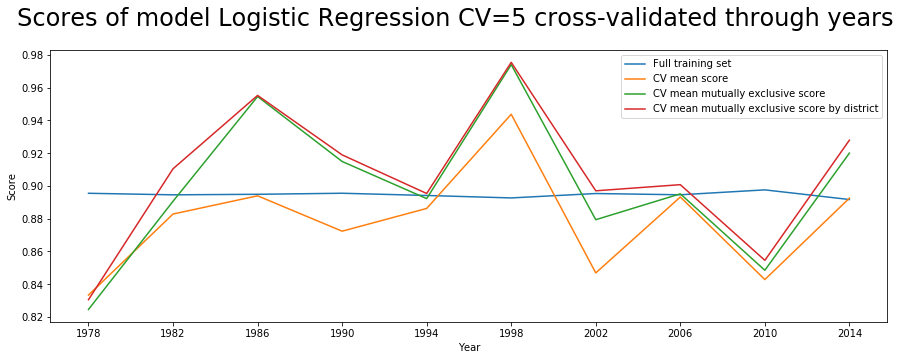

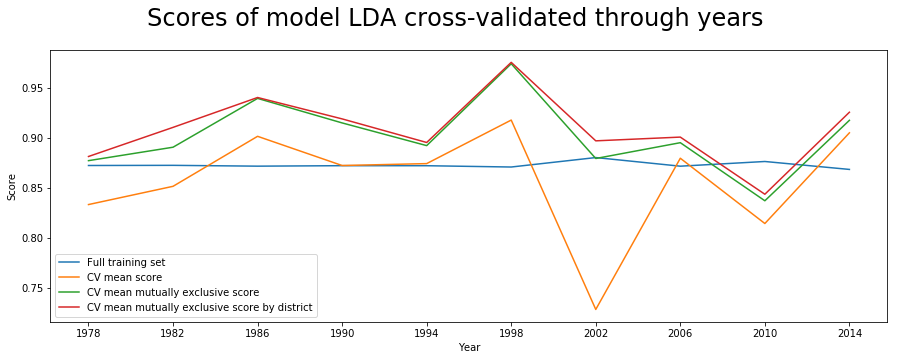

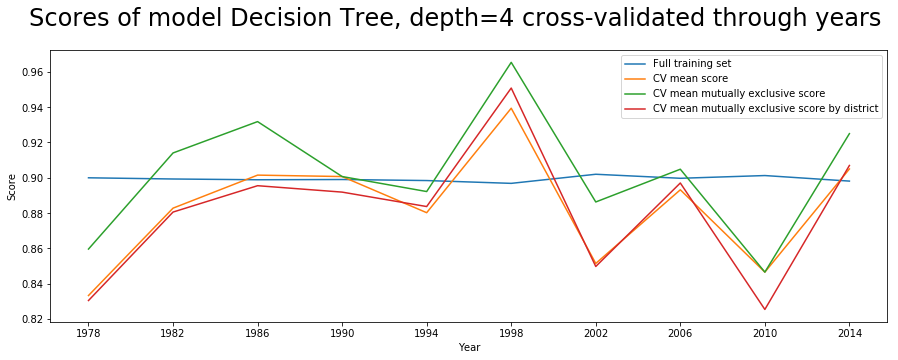

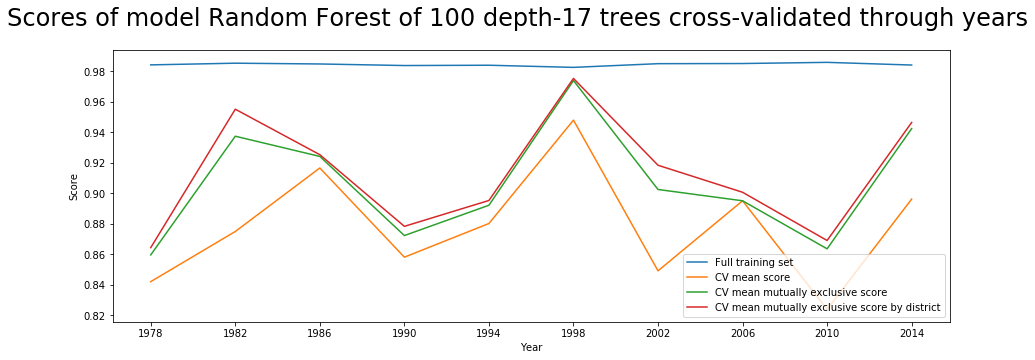

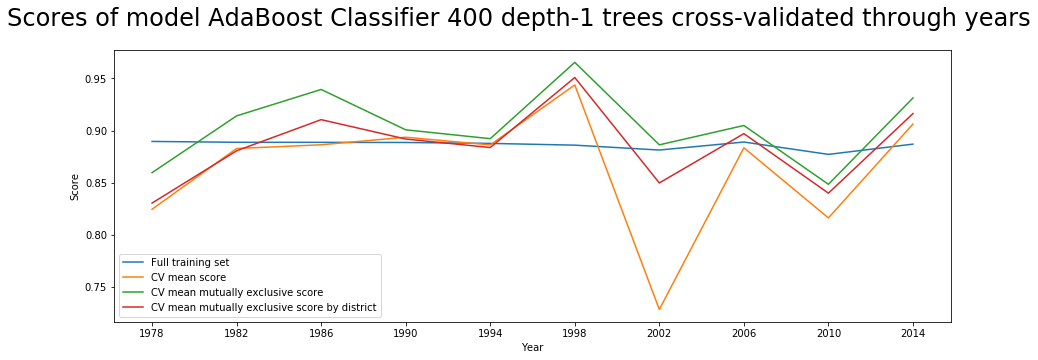

In [16]:
#train models using cross-validation through the years and calculate accuracies
modelListTrain(modelList, train_data, Midterm_recent_years)

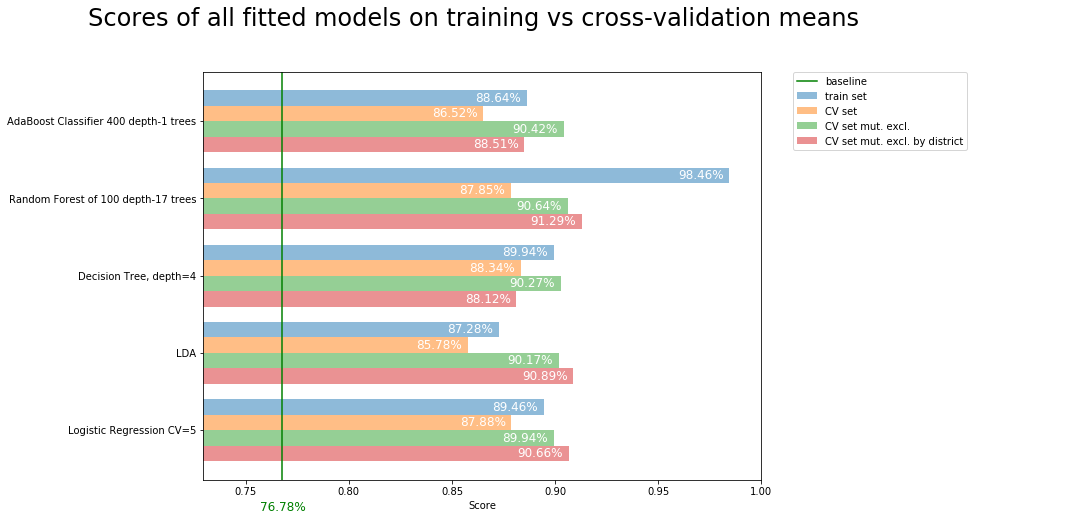

In [17]:
plotModelsScores(modelList, baseline_accuracy)

We notice how the single best performing model is random forest, with depth=17 and 100 iterations 

The mean score over the validation folds is improved by the mutually exclusive function. This score is still relative to the single candidates.

Then we extract only the predicted winners in each district and we compare them with the party of real winners. That is the validation set mutually excusive by district. 

The latter score is what we aim to optimize, as our purpose is to predict the winning party in each district.

Let's now try to improve this using stacking

In [75]:
#def var_sel_RF(forest_df,forest_cat=forest_cat,y_year=2018, threshold=0.003):
def var_sel_RF_2(x_train, y_train, x_test, y_test, threshold=0.003):
    #returns 1) sorted list of most important features
    #        2) Accuracy of model with all features and with selected features
    #thresold: minimum feature importance
    
    #x_train, y_train, x_test, y_test = one_hot_coding(forest_df,forest_cat,y_year)
    
    # Create a random forest classifier. number of trees set to 100
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    
    # Train the classifier
    clf.fit(x_train, y_train)
    feat_labels = x_train.columns
    feat_imp = []
    
    # name and gini importance of each feature
    for feature in zip(clf.feature_importances_,feat_labels):
        feat_imp.append(feature)
    feat_imp.sort(reverse=True)
    
    #sorted list with most important features
    feat_imp = list(filter(lambda x: x[0] > threshold, feat_imp))
    
    # Create a selector object that will use the random forest classifier to identify
    # features that have an importance of more than 0.003
    sfm = SelectFromModel(clf, threshold=threshold)

    # Train the selector
    sfm.fit(x_train, y_train)
    
    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    X_important_train = sfm.transform(x_train)
    X_important_test = sfm.transform(x_test)
    
    # Create a new random forest classifier for the most important features
    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

    # Train the new classifier on the new dataset containing the most important features
    clf_important.fit(X_important_train, y_train)
    
    # Accuracy of model with all features
    y_pred = clf.predict(x_test)
    print('Accuracy of model with all features: {}'.format(accuracy_score(y_test, y_pred)))
    
    # Accuracy of model with most important features
    y_important_pred = clf_important.predict(X_important_test)
    print('Accuracy of model with most important features: {}'.format(accuracy_score(y_test, y_important_pred)))
    featList=pd.DataFrame(feat_imp)[1]
    print('Features to drop: {}'.format(list(set(x_train)-set(featList))))
    return feat_imp

In [76]:
x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party = pre_process(house_df, 2018)
var_sel_RF_2(x_train_designFeatures, y_train, x_test_designFeatures, y_test)

Accuracy of model with all features: 0.8630952380952381
Accuracy of model with most important features: 0.8630952380952381
['president_party', 'own_president_party']


[(0.23735628151865004, 'is_incumbent'),
 (0.19909898780091684, 'Log10fundraising'),
 (0.14270651675414023, 'count_victories'),
 (0.10758338569909746, 'first_time_elected'),
 (0.07699452340929333, 'ownPartisan'),
 (0.03429673575206901, 'unemployement_rate'),
 (0.028080821194309574, 'year'),
 (0.021150025068691618, 'last_own_party_Seats'),
 (0.02029397268826362, 'last_R_vs_D_Seats'),
 (0.01870644384358848, 'unemployement_rate_own_president'),
 (0.01870533395176606, 'unemployement_rate_president_opposition'),
 (0.01273347600177893, 'president_overall_avg_job_approval'),
 (0.012391393889973979, 'partisanship_2'),
 (0.009945248137330803, 'own_president_job_approval'),
 (0.009419255896758674, 'partisanship_3'),
 (0.008703391207948845, 'partisanship_1'),
 (0.008533247474377004, 'president_opposition_job_approval'),
 (0.006647260871429544, 'swingDistrict'),
 (0.0056971586993527935, 'is_presidential_year'),
 (0.005111471178759839, 'party'),
 (0.004437319418593154, 'last_house_majority'),
 (0.00

In [ ]:
#evaluate feature importance for random forest, through all folds, excluding 2018 data
feat_df=pd.DataFrame(list(x_train_designFeatures), columns=['feature']).set_index('feature')
for year in Midterm_recent_years:
    print('year: {}'.format(year))
    x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party = pre_process(house_df[house_df['year']!=2018], year)
    feat_imp=var_sel_RF_2(x_train_designFeatures, y_train, x_test_designFeatures, y_test, 0)
    feat_df=feat_df.join(pd.DataFrame(feat_imp).set_index([1]).rename(index=str, columns={0:year}))
feat_df['mean']=feat_df.mean(axis=1)
display(feat_df.sort_values(by=['mean'], ascending=False))    

In [18]:
def featureImportance(x, y):
    scores, pvalues = chi2(x, y)
    featureImportance=pd.DataFrame([list(x), list(pvalues)]).T
    featureImportance.columns=['coeff', 'p-value']
    featureImportance=featureImportance.set_index('coeff')
    display(featureImportance)

To do stacking, we will store the predictions of a list of models, one column per model and its probability

We will predict results for a list of years (excluding 2018), using the other years data as training. 

Then we will use this data to fit the stacking linear model

In [19]:
#Stacking all models
def predictForStack(df, years, modelList):
    train_data=df.copy()
    stackCols=['state', 'district', 'baseline', 'baseline_proba']
    for i in range(len(modelList)):
        stackCols.append('pred_{}'.format(i))
        stackCols.append('proba_{}'.format(i))
    stackCols.append('party')
    predictionsToStack=pd.DataFrame(columns=stackCols)
    for year in years:        
        #pre_process
        x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)

        #baseline model predictions
        y_pred=baselineTrain(train_data[train_data['year']!=year]).set_index(['state', 'district']).sort_index().astype(float) #train simple average model, remove 2018 results
        y_pred=y_pred.rename(index=str, columns={'party': 'baseline', 'proba': 'baseline_proba'})

        for i, model in enumerate(modelList):
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #predictions by district and winning party only
            y_pred_i=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
            y_pred_i['proba_{}'.format(i)]=y_pred_i['rel_won_proba']
            y_pred_i=y_pred_i.drop(columns=['abs_won_proba', 'won_pred', 'rel_won_proba'])
            y_pred_i=y_pred_i.rename(index=str, columns={'party': 'pred_{}'.format(i)})

            #Add column with current model predictions
            y_pred = pd.concat([y_pred, y_pred_i], axis=1).fillna(-1)
            y_pred['proba_{}'.format(i)]=y_pred['proba_{}'.format(i)].replace(-1,0)
        y_pred['baseline_proba']=y_pred['baseline_proba'].replace(-1,0)
        #Add last column with actual results
        y_val=winnerFilter(train_data[train_data['year']==year]).set_index(['state', 'district']).sort_index() #extract winner party for each district in 2018
        y_pred=y_pred.join(y_val).dropna()

        #Append all models predictions for current year to the other years' predictions
        predictionsToStack=predictionsToStack.append(y_pred.reset_index(drop=False)[stackCols])  
    #if asking only for one year, return predictions by state and district, without actual results (it means it's for 2018)
    if (len(years)==1): 
        return predictionsToStack.drop('party', axis=1).set_index(['state', 'district']).sort_index()
    #if asking for several years, predictions and actual results will be used to fit a stacking model, so remove state, district index and include actual results
    return predictionsToStack.drop(columns=['state', 'district'])

First we generate the predictions for all available models:

In [20]:
#Generate predictions for stacking
predictionsToStack=predictForStack(train_data, Midterm_recent_years, modelList)

model: Logistic Regression CV=5
year: 2014
model: LDA
year: 2014
model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
25 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
199,Michigan,District 11,2.0
200,Michigan,District 12,2.0
201,Michigan,District 14,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.18673,1.0,0.37346,0.5
8120,Arkansas,District 2,1.0,0.18673,1.0,0.37346,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.894206,0.0,0.976625,-0.526534,-0.527394,-0.028693,0.434383,1.0,0.0,0.0,1.0,-0.510698,0.906543,-0.992113,0.894873,-0.914246,0.18673
8120,Arkansas,District 2,-0.894206,1.0,0.976625,-0.526534,-0.527394,-0.028693,0.222474,0.0,1.0,0.0,1.0,0.510036,-0.977267,0.891796,-0.900036,0.885220,0.18673


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Random Forest of 100 depth-17 trees
year: 2014
model: AdaBoost Classifier 400 depth-1 trees
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
19 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0
208,Michigan,District 8,2.0
240,New Jersey,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.398884,1.0,0.797768,0.5
8120,Arkansas,District 2,1.0,0.398884,1.0,0.797768,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.894206,0.0,0.976625,-0.526534,-0.527394,-0.028693,0.434383,1.0,0.0,0.0,1.0,-0.510698,0.906543,-0.992113,0.894873,-0.914246,0.398884
8120,Arkansas,District 2,-0.894206,1.0,0.976625,-0.526534,-0.527394,-0.028693,0.222474,0.0,1.0,0.0,1.0,0.510036,-0.977267,0.891796,-0.900036,0.885220,0.398884


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Logistic Regression CV=5
year: 2010
model: LDA
year: 2010
model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
15 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
176,Mississippi,District 4,2.0
198,New York,District 20,2.0
221,Ohio,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.204904,1.0,0.409807,0.5
6570,Alabama,District 5,0.0,0.204904,1.0,0.409807,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.89905,1.0,0.689902,-0.51952,-0.521649,1.552811,0.226249,0.0,0.0,0.0,1.0,-1.299913,-0.981587,0.898741,-0.903949,1.837171,0.204904
6570,Alabama,District 5,-0.89905,0.0,0.689902,-0.51952,-0.521649,1.552811,0.265424,1.0,1.0,0.0,1.0,1.294483,0.906261,-0.988616,1.815827,-0.913006,0.204904


model: Random Forest of 100 depth-17 trees
year: 2010
model: AdaBoost Classifier 400 depth-1 trees
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
8 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
270,Virginia,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.398536,1.0,0.797072,0.5
6570,Alabama,District 5,0.0,0.398536,1.0,0.797072,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.89905,1.0,0.689902,-0.51952,-0.521649,1.552811,0.226249,0.0,0.0,0.0,1.0,-1.299913,-0.981587,0.898741,-0.903949,1.837171,0.398536
6570,Alabama,District 5,-0.89905,0.0,0.689902,-0.51952,-0.521649,1.552811,0.265424,1.0,1.0,0.0,1.0,1.294483,0.906261,-0.988616,1.815827,-0.913006,0.398536


model: Logistic Regression CV=5
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.079562,0.0,0.288663,0.275621
5538,Texas,District 22,1.0,0.104551,1.0,0.288663,0.362189
5539,Texas,District 22,1.0,0.104551,1.0,0.288663,0.362189


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.079562
5538,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.104551
5539,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.104551


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.012519,0.0,0.053948,0.232053
5538,Texas,District 22,1.0,0.020714,1.0,0.053948,0.383974
5539,Texas,District 22,1.0,0.020714,1.0,0.053948,0.383974


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.012519
5538,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.020714
5539,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.020714


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.144578,1.0,0.289157,0.5
5534,Arizona,District 8,1.0,0.144578,1.0,0.289157,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.144578
5534,Arizona,District 8,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.144578


model: Random Forest of 100 depth-17 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.018237,0.0,0.336091,0.054262
5538,Texas,District 22,1.0,0.158927,1.0,0.336091,0.472869
5539,Texas,District 22,1.0,0.158927,1.0,0.336091,0.472869


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.018237
5538,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.158927
5539,Texas,District 22,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.166517,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.158927


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.398384,1.0,0.796768,0.5
5534,Arizona,District 8,1.0,0.398384,1.0,0.796768,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.896452,0.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,0.0,0.0,0.0,0.0,-0.472004,-0.982114,0.958255,-0.907087,0.305498,0.398384
5534,Arizona,District 8,-0.896452,1.0,0.444687,-0.519591,-0.520712,-1.036803,0.648758,1.0,1.0,0.0,0.0,0.469861,0.964284,-0.987817,0.305030,-0.914455,0.398384


model: Logistic Regression CV=5
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.39901,1.0,1.197031,0.333333
4460,Louisiana,District 1,1.0,0.39901,1.0,1.197031,0.333333
4461,Louisiana,District 1,1.0,0.39901,1.0,1.197031,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.39901
4460,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.39901
4461,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.39901


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.144755,1.0,0.434265,0.333333
4460,Louisiana,District 1,1.0,0.144755,1.0,0.434265,0.333333
4461,Louisiana,District 1,1.0,0.144755,1.0,0.434265,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.144755
4460,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.144755
4461,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.144755


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
28 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
74,Colorado,District 4,2.0
93,Florida,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.172109,1.0,0.344219,0.5
4512,Alabama,District 5,1.0,0.172109,1.0,0.344219,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.917193,0.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,0.0,0.0,0.0,1.0,-0.140920,-0.978454,0.954936,-0.897767,0.682776,0.172109
4512,Alabama,District 5,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,1.0,1.0,0.0,1.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.172109


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Random Forest of 100 depth-17 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.577405,1.0,1.732214,0.333333
4460,Louisiana,District 1,1.0,0.577405,1.0,1.732214,0.333333
4461,Louisiana,District 1,1.0,0.577405,1.0,1.732214,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.577405
4460,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.577405
4461,Louisiana,District 1,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,-1.910942,1.0,1.0,1.0,0.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.577405


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
28 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
74,Colorado,District 4,2.0
93,Florida,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.397679,1.0,0.795358,0.5
4512,Alabama,District 5,1.0,0.397679,1.0,0.795358,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.917193,0.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,0.0,0.0,0.0,1.0,-0.140920,-0.978454,0.954936,-0.897767,0.682776,0.397679
4512,Alabama,District 5,-0.917193,1.0,0.204088,-0.534474,-0.534824,-0.366588,0.027305,1.0,1.0,0.0,1.0,0.141893,0.968457,-0.991825,0.684157,-0.911364,0.397679


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Logistic Regression CV=5
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.172418,0.0,0.563081,0.306206
3719,California,District 1,1.0,0.195331,1.0,0.563081,0.346897
3720,California,District 1,1.0,0.195331,1.0,0.563081,0.346897


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.172418
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.195331
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.195331


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.047558,0.0,0.178636,0.266230
3719,California,District 1,1.0,0.065539,1.0,0.178636,0.366885
3720,California,District 1,1.0,0.065539,1.0,0.178636,0.366885


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.047558
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.065539
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.065539


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.227609,1.0,0.682827,0.333333
3719,California,District 1,1.0,0.227609,1.0,0.682827,0.333333
3720,California,District 1,1.0,0.227609,1.0,0.682827,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.227609
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.227609
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.227609


model: Random Forest of 100 depth-17 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.102101,0.0,0.310136,0.329213
3719,California,District 1,1.0,0.104018,1.0,0.310136,0.335393
3720,California,District 1,1.0,0.104018,1.0,0.310136,0.335393


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.102101
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.104018
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.104018


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.403111,1.0,1.209334,0.333333
3719,California,District 1,1.0,0.403111,1.0,1.209334,0.333333
3720,California,District 1,1.0,0.403111,1.0,1.209334,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.899339,0.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,1.0,0.0,0.0,1.0,-0.349292,1.200310,-0.990965,0.348775,-0.914077,0.403111
3719,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.403111
3720,California,District 1,-0.899339,1.0,-0.031342,-0.526874,-0.527164,-0.948637,0.111534,0.0,1.0,0.0,1.0,0.350265,-0.980434,1.189670,-0.902913,0.346713,0.403111


model: Logistic Regression CV=5
year: 1994
model: LDA
year: 1994
model: Decision Tree, depth=4
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.224673,1.0,0.449346,0.5
3354,California,District 44,1.0,0.224673,1.0,0.449346,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.898737,0.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,1.0,1.0,0.0,1.0,1.331082,1.198758,-0.991222,0.719553,-0.911929,0.224673
3354,California,District 44,-0.898737,1.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,0.0,0.0,0.0,1.0,-1.330705,-0.980281,1.187604,-0.900449,0.719994,0.224673


model: Random Forest of 100 depth-17 trees
year: 1994
model: AdaBoost Classifier 400 depth-1 trees
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.402569,1.0,0.805139,0.5
3354,California,District 44,1.0,0.402569,1.0,0.805139,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.898737,0.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,1.0,1.0,0.0,1.0,1.331082,1.198758,-0.991222,0.719553,-0.911929,0.402569
3354,California,District 44,-0.898737,1.0,-0.263048,-0.528913,-0.529688,-0.311632,0.310873,0.0,0.0,0.0,1.0,-1.330705,-0.980281,1.187604,-0.900449,0.719994,0.402569


model: Logistic Regression CV=5
year: 1990
model: LDA
year: 1990
model: Decision Tree, depth=4
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.223464,1.0,0.446927,0.5
3063,Colorado,District 4,1.0,0.223464,1.0,0.446927,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.899054,0.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,0.0,1.0,0.0,1.0,1.376710,-0.980907,1.422034,-0.900565,0.749235,0.223464
3063,Colorado,District 4,-0.899054,1.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,1.0,0.0,0.0,1.0,-1.375652,1.433145,-0.991827,0.748574,-0.912018,0.223464


model: Random Forest of 100 depth-17 trees
year: 1990
model: AdaBoost Classifier 400 depth-1 trees
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.402732,1.0,0.805463,0.5
3063,Colorado,District 4,1.0,0.402732,1.0,0.805463,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.899054,0.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,0.0,1.0,0.0,1.0,1.376710,-0.980907,1.422034,-0.900565,0.749235,0.402732
3063,Colorado,District 4,-0.899054,1.0,-0.494747,-0.524773,-0.526142,-0.263236,0.386242,1.0,0.0,0.0,1.0,-1.375652,1.433145,-0.991827,0.748574,-0.912018,0.402732


model: Logistic Regression CV=5
year: 1986
model: LDA
year: 1986
model: Decision Tree, depth=4
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
54,Maryland,District 8,2.0
62,Utah,District 2,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.2224,1.0,0.4448,0.5
2736,California,District 12,0.0,0.2224,1.0,0.4448,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.900423,1.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,1.0,0.0,0.0,1.0,-1.142871,1.104989,-0.991002,1.061153,-0.911517,0.2224
2736,California,District 12,-0.900423,0.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,0.0,1.0,0.0,1.0,1.144154,-0.980360,1.094175,-0.900283,1.064466,0.2224


model: Random Forest of 100 depth-17 trees
year: 1986
model: AdaBoost Classifier 400 depth-1 trees
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
54,Maryland,District 8,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.402695,1.0,0.80539,0.5
2736,California,District 12,0.0,0.402695,1.0,0.80539,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.900423,1.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,1.0,0.0,0.0,1.0,-1.142871,1.104989,-0.991002,1.061153,-0.911517,0.402695
2736,California,District 12,-0.900423,0.0,-0.727677,-0.524881,-0.526039,0.261976,0.631156,0.0,1.0,0.0,1.0,1.144154,-0.980360,1.094175,-0.900283,1.064466,0.402695


model: Logistic Regression CV=5
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.180060,1.0,0.522512,0.344605
2528,California,District 43,0.0,0.162392,0.0,0.522512,0.310791
2569,California,District 43,1.0,0.180060,1.0,0.522512,0.344605


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.180060
2528,California,District 43,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.162392
2569,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.180060


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.060349,1.0,0.171622,0.351639
2528,California,District 43,0.0,0.050924,0.0,0.171622,0.296722
2569,California,District 43,1.0,0.060349,1.0,0.171622,0.351639


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.060349
2528,California,District 43,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.050924
2569,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.060349


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.2216,1.0,0.4432,0.5
2500,California,District 12,0.0,0.2216,1.0,0.4432,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.2216
2500,California,District 12,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.2216


model: Random Forest of 100 depth-17 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.329978,1.0,0.929421,0.355036
2528,California,District 43,0.0,0.269466,0.0,0.929421,0.289929
2569,California,District 43,1.0,0.329978,1.0,0.929421,0.355036


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.329978
2528,California,District 43,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.269466
2569,California,District 43,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,-0.038893,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.329978


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.402337,1.0,0.804674,0.5
2500,California,District 12,0.0,0.402337,1.0,0.804674,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.900929,1.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,1.0,0.0,0.0,1.0,-0.816826,1.105213,-0.991255,2.046136,-0.915076,0.402337
2500,California,District 12,-0.900929,0.0,-0.96243,-0.527296,-0.528001,1.938623,0.631541,0.0,1.0,0.0,1.0,0.817529,-0.980122,1.093848,-0.903177,2.056398,0.402337


model: Logistic Regression CV=5
year: 1978
model: LDA
year: 1978
model: Decision Tree, depth=4
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.221069,1.0,0.442139,0.5
2216,California,District 18,0.0,0.221069,1.0,0.442139,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.899952,1.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,0.0,0.0,0.0,1.0,-2.478835,-0.980278,0.801780,-0.900744,0.721319,0.221069
2216,California,District 18,-0.899952,0.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,1.0,1.0,0.0,1.0,2.479563,0.813050,-0.991392,0.721056,-0.912390,0.221069


model: Random Forest of 100 depth-17 trees
year: 1978
model: AdaBoost Classifier 400 depth-1 trees
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.401614,1.0,0.803229,0.5
2216,California,District 18,0.0,0.401614,1.0,0.803229,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.899952,1.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,0.0,0.0,0.0,1.0,-2.478835,-0.980278,0.801780,-0.900744,0.721319,0.401614
2216,California,District 18,-0.899952,0.0,-1.197412,-0.526878,-0.52772,-0.310493,0.16327,1.0,1.0,0.0,1.0,2.479563,0.813050,-0.991392,0.721056,-0.912390,0.401614


In [21]:
#display prediction table for stacking and model names legenda
display(predictionsToStack.head())
for i in range(len(modelList)):
    print(i, modelList[i]['name'])

,baseline,baseline_proba,pred_0,proba_0,pred_1,proba_1,pred_2,proba_2,pred_3,proba_3,pred_4,proba_4,party
0,1.0,1.000000,1.0,0.945558,1.0,0.989525,1.0,0.939117,1.0,0.983914,1.0,0.650932,1.0
1,1.0,0.857143,1.0,0.941978,1.0,0.988813,1.0,0.939117,1.0,0.983205,1.0,0.661054,1.0
2,1.0,1.000000,1.0,0.947835,1.0,0.989865,1.0,0.939117,1.0,0.993137,1.0,0.661054,1.0
3,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,0.0,0.571429,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


0 Logistic Regression CV=5
1 LDA
2 Decision Tree, depth=4
3 Random Forest of 100 depth-17 trees
4 AdaBoost Classifier 400 depth-1 trees


Then, we select which models to use to train our stacking model.

The selection is done by looking at the coefficients of the model, taking only the biggest ones

In [39]:
#Select which model predictions to stack
selCols=[8,10,12]
X=predictionsToStack.iloc[:,selCols].drop('party', axis=1).astype(float)
y=predictionsToStack.iloc[:,selCols]['party'].astype(float)
stackingModel = LogisticRegression(C=1000, solver='lbfgs').fit(X,y)
print('Training accuracy of the stacking model: {:.2%}'.format(stackingModel.score(X,y)))
print('Stacking model coefficients: {}'.format(stackingModel.coef_))

Training accuracy of the stacking model: 91.51%
Stacking model coefficients: [[4.05055512 1.00061651]]


The score has improved a little bit, so let's go on with 2018 data. 

First we produce the predictions for 2018 data using all models: 

In [23]:
#split dataset using 2018 data as test set
year=2018
data=house_df[(house_df['year']>=yearStart)]
predictions2018toStack=predictForStack(data, [year], modelList)

model: Logistic Regression CV=5
year: 2018
model: LDA
year: 2018
model: Decision Tree, depth=4
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
27 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
95,Florida,District 17,2.0
106,Florida,District 27,2.0
144,Illinois,District 4,2.0
212,Minnesota,District 1,2.0
222,Mississippi,District 3,2.0
239,Nevada,District 4,2.0
244,New Jersey,District 11,2.0
246,New Jersey,District 2,2.0
296,North Carolina,District 9,2.0
297,North Dakota,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9865,Florida,District 17,1.0,0.221529,1.0,0.443058,0.5
9869,Florida,District 17,0.0,0.221529,1.0,0.443058,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9865,Florida,District 17,-0.899724,1.0,1.115292,-0.526795,-0.527785,-1.301668,0.013442,1.0,1.0,0.0,1.0,0.755423,0.578521,-0.991365,0.135441,-0.913130,0.221529
9869,Florida,District 17,-0.899724,0.0,1.115292,-0.526795,-0.527785,-1.301668,0.013442,0.0,0.0,0.0,1.0,-0.754730,-0.980407,0.567407,-0.901607,0.131453,0.221529


model: Random Forest of 100 depth-17 trees
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
347,South Carolina,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9746,South Carolina,District 4,0.0,0.01,1.0,0.02,0.5
9748,South Carolina,District 4,1.0,0.01,1.0,0.02,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9746,South Carolina,District 4,-0.899724,0.0,1.115292,-0.526795,-0.527785,-1.301668,-1.958729,0.0,0.0,0.0,0.0,-0.754730,-0.980407,0.567407,-0.901607,0.131453,0.01
9748,South Carolina,District 4,-0.899724,1.0,1.115292,-0.526795,-0.527785,-1.301668,-1.958729,1.0,1.0,0.0,0.0,0.755423,0.578521,-0.991365,0.135441,-0.913130,0.01


model: AdaBoost Classifier 400 depth-1 trees
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
31 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
16,Arizona,District 9,2.0
95,Florida,District 17,2.0
106,Florida,District 27,2.0
200,Michigan,District 11,2.0
212,Minnesota,District 1,2.0
219,Minnesota,District 8,2.0
222,Mississippi,District 3,2.0
239,Nevada,District 4,2.0
240,New Hampshire,District 1,2.0
244,New Jersey,District 11,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9291,Arizona,District 9,0.0,0.397807,1.0,0.795613,0.5
9292,Arizona,District 9,1.0,0.397807,1.0,0.795613,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9291,Arizona,District 9,-0.899724,0.0,1.115292,-0.526795,-0.527785,-1.301668,0.494702,0.0,0.0,0.0,0.0,-0.754730,-0.980407,0.567407,-0.901607,0.131453,0.397807
9292,Arizona,District 9,-0.899724,1.0,1.115292,-0.526795,-0.527785,-1.301668,0.316310,1.0,1.0,0.0,0.0,0.755423,0.578521,-0.991365,0.135441,-0.913130,0.397807


Then we select the models to stack according to the selection used for model fit.

We have obtained our final predictions

In [40]:
selCols_=selCols[:-1]
X=predictions2018toStack.iloc[:,selCols_].copy().astype(float)
X['stackedPredictions']=stackingModel.predict(X)
X, y_pred_stacked_2018=X.drop('stackedPredictions', axis=1), X['stackedPredictions']
pred2018_accuracy=districtAccuracy(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #, partyWonCol='party', set_index=1)
print('The accuracy of our predictions for 2018 midterm elections is {:.2%}'.format(pred2018_accuracy))
pred2018=districtPredictions(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #year, partyWonCol='party', set_index=1):

The accuracy of our predictions for 2018 midterm elections is 89.89%


What we need to do now is to prepare the table for the map, in csv format, with predictions, probabilities and actual results

In [25]:
#calculate stacked probabilities 
probabilities=list(np.array(selCols_)+1)
pred2018['proba']=predictions2018toStack.iloc[:,probabilities].dot(stackingModel.coef_.T)/np.sum(stackingModel.coef_)

In [26]:
#Salve .csv file
pred2018=pred2018.rename(index=str, columns={'partyWon':'won', 'stackedPredictions':'won_pred', 'proba':'rel_won_proba'})
pred2018['correct_pred']=(pred2018['won']==pred2018['won_pred'])
pred2018.to_csv('data/final_results_map.csv', index=True)
display(pred2018.head())

won  won_pred  rel_won_proba  correct_pred
state   district                                              
Alabama District 1    1       1.0       0.921525          True
        District 2    1       1.0       0.922189          True
        District 3    1       1.0       0.838825          True
        District 4    1       1.0       0.925465          True
        District 5    1       1.0       0.874176          True

In [27]:
pred2018.describe()

,won,won_pred,rel_won_proba
count,435.000000,435.000000,435.000000
mean,0.471264,0.563218,0.810215
std,0.499748,0.496558,0.139577
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.743609
50%,0.000000,1.000000,0.836117
75%,1.000000,1.000000,0.915515
max,1.000000,1.000000,1.000000


In [28]:
#print how many republican, how many democrat districts
DEM=pred2018[pred2018['won_pred']==0]
REP=pred2018[pred2018['won_pred']==1]
print('Predictions:\nN. Democrat districts: {}\nN. Republican districts: {}\n'.format(len(DEM), len(REP)))
DEM=results[2018][results[2018]['partyWon']==0]
REP=results[2018][results[2018]['partyWon']==1]
print('Actual results:\nN. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

Predictions:
N. Democrat districts: 190
N. Republican districts: 245

Actual results:
N. Democrat districts: 230
N. Republican districts: 205


In the next lines we have evaluated the best parameters for decision trees, random forest and boosting

In [29]:
#find best depth for decision tree
years=Midterm_recent_years[:5]
#for year in years:
for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
            
    #fit model
    depths=list(range(1,41)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_designFeatures, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_designFeatures, y_train)
        scores_train.append(dt.score(x_train_designFeatures, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [30]:
#plot staged scores on ax
def plotScoreVsIter(boost, X, y, ax, label='Train set, AdaBoost', linestyle='-', color='blue'):
    xticks=np.arange(1,len(boost.estimators_)+1)
    ax.plot(xticks, list(boost.staged_score(X,y)), linestyle, c=color, label = label)

#plot a list of models scores
def PlotAdaBoost3(modelList, X_train, y_train, X_test, y_test, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(title, fontsize=24, y=1.0)
    colors=sns.color_palette('colorblind', len(modelList))
    for model, c in zip(modelList, colors):
        plotScoreVsIter(model['model'], X_train, y_train, ax, 'Train set, {}'.format(model['name']), '--', c)
        plotScoreVsIter(model['model'], X_test, y_test, ax, 'Test set, {}'.format(model['name']), color=c)
    ax.set_xlabel('number of iterations')
    ax.set_ylabel('Score')
    lgd = ax.legend(bbox_to_anchor=(1, 0.1), loc='lower left', borderaxespad=1);
    fig.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight') #to avoid cutoff legend
    #I choosed to use the same color for train and test sets and changing only the linestyle
    #It is more convenient when displaying more than one boosting model
    #As a future improvement I would split the legend in 2, one for colors and one for linestyle.

In [31]:
#find best depth for decision tree and best n_estimators
years=Midterm_recent_years[:5]
#for year in years:
for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
    
    #fit AdaBoost classifiers for tree depth = 1,2,4
    n_trees=800
    lrate=0.01
    for i in [1,2,4]:
        abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), n_estimators=n_trees, learning_rate=lrate)
        model=dict()
        model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, i)
        model['model']=abc.fit(x_train_designFeatures, y_train)
        model['training accuracy']=model['model'].score(x_train_designFeatures, y_train)
        model['test accuracy']=model['model'].score(x_val_designFeatures, y_val)
        modelList.append(model)
    plotList=modelList[-3:]
    title='{}. Boosting score vs number of iterations'.format(year)
    PlotAdaBoost3(plotList, x_train_designFeatures, y_train, x_val_designFeatures, y_val, title)